In [32]:
import sys
sys.path.insert(0,'../src/')
from curve import *
from utils import *
from multiply_connected_pipe import MultiplyConnectedPipe
import numpy as np
import pickle
from matplotlib import pyplot as plt
import scipy as sp
from mat_vec import mat_vec_constructor
from scipy.sparse.linalg import gmres, LinearOperator


In [33]:
with open('./pipes_and_shifts.pickle','rb') as f:
    pipes, shifts = pickle.load(f)

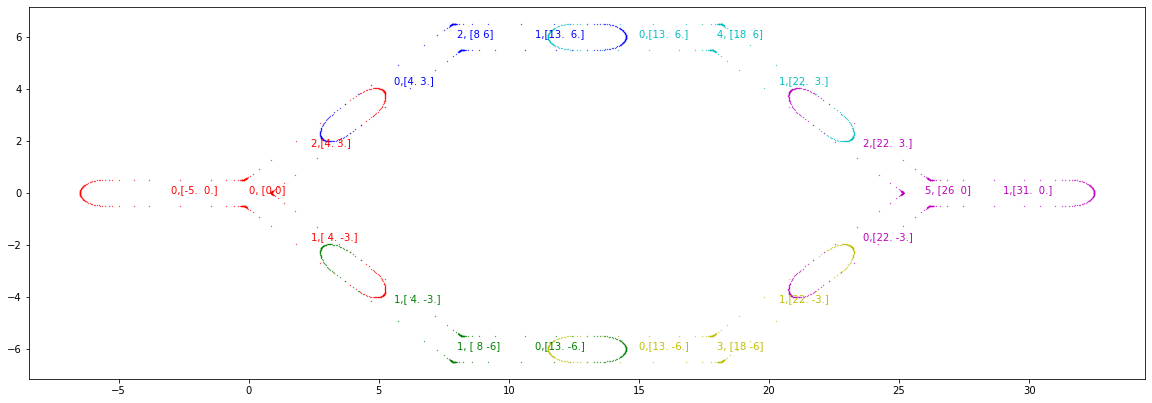

In [34]:
color = ['r','g','b','y','c','m','k']

fig,ax = plt.subplots(figsize=(20,10))
ax.set_aspect('equal')

for a,i,j,c in zip(range(10),pipes,shifts,color):
    panel_break_pts = np.array([cplx2pt(p.start_pt) + j for p in i.panels])
    ax.scatter(panel_break_pts[:,0], panel_break_pts[:,1],c=c,s=0.1)
    for k,let in enumerate(i.lets):
        ax.text(*(0.6*let.matching_pt + j),f'{k},{let.matching_pt + j}',color=c)
    ax.text(*j,f'{a}, {j}',color=c)

In [35]:
pipe = pipes[0]
panels = pipe.panels
pairs = pipe.mat_vec.close_panel_interactions
pipe.mat_vec.build_k()